In [178]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm
import pandas as pd

In [179]:
symbol = "RELIANCE.NS"        
period = "5y"
r = 0.05
T = 1.0
N = 100_000
seed = 2025

In [180]:
rng = np.random.default_rng(seed)


In [181]:
df = yf.download(symbol, period=period, progress=False); prices = (df.loc[:, df.columns.get_level_values(0).isin(["Adj Close","Close"])].xs("Adj Close", level=0, axis=1).squeeze().dropna() if isinstance(df.columns, pd.MultiIndex) and "Adj Close" in df.columns.get_level_values(0) else (df.loc[:, df.columns.get_level_values(0).isin(["Adj Close","Close"])].iloc[:,0].squeeze().dropna() if isinstance(df.columns, pd.MultiIndex) else (df["Adj Close"] if "Adj Close" in df.columns else df["Close"]).dropna())); S0 = float(prices.iloc[-1])


C:\Users\vidya\AppData\Local\Temp\ipykernel_33008\1787730376.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period=period, progress=False); prices = (df.loc[:, df.columns.get_level_values(0).isin(["Adj Close","Close"])].xs("Adj Close", level=0, axis=1).squeeze().dropna() if isinstance(df.columns, pd.MultiIndex) and "Adj Close" in df.columns.get_level_values(0) else (df.loc[:, df.columns.get_level_values(0).isin(["Adj Close","Close"])].iloc[:,0].squeeze().dropna() if isinstance(df.columns, pd.MultiIndex) else (df["Adj Close"] if "Adj Close" in df.columns else df["Close"]).dropna())); S0 = float(prices.iloc[-1])


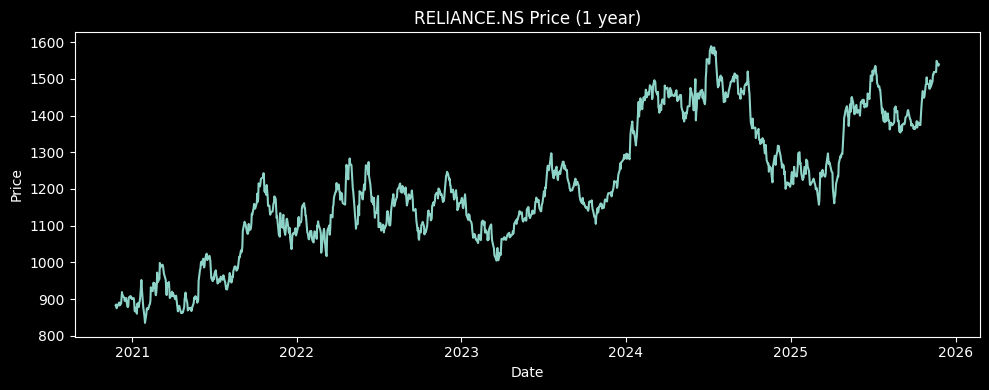

In [182]:
# plot the price
plt.style.use("dark_background")
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.title(f"{symbol} Price (1 year)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

In [183]:
#  Compute log returns + sample sigma 
logret = np.log(prices/prices.shift(1)).dropna()
sigma_sample = logret.std(ddof=1) * np.sqrt(252)


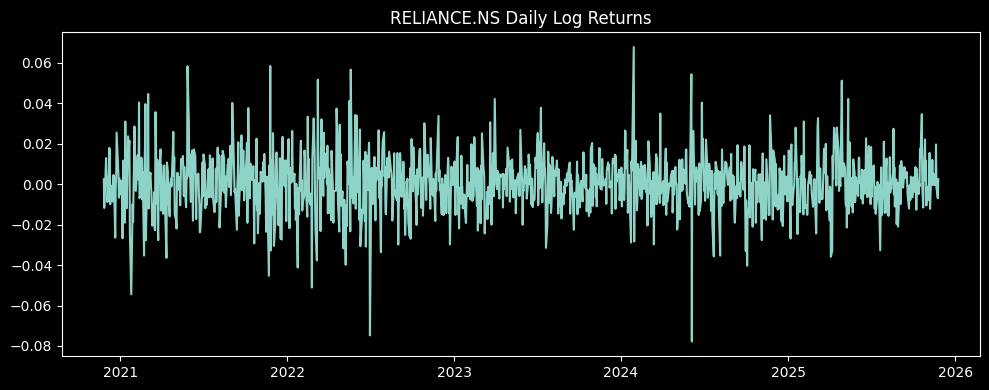

In [184]:
# plot log returns
plt.style.use("dark_background")
plt.figure(figsize=(10,4))
plt.plot(logret)
plt.title(f"{symbol} Daily Log Returns")
plt.tight_layout()
plt.show()

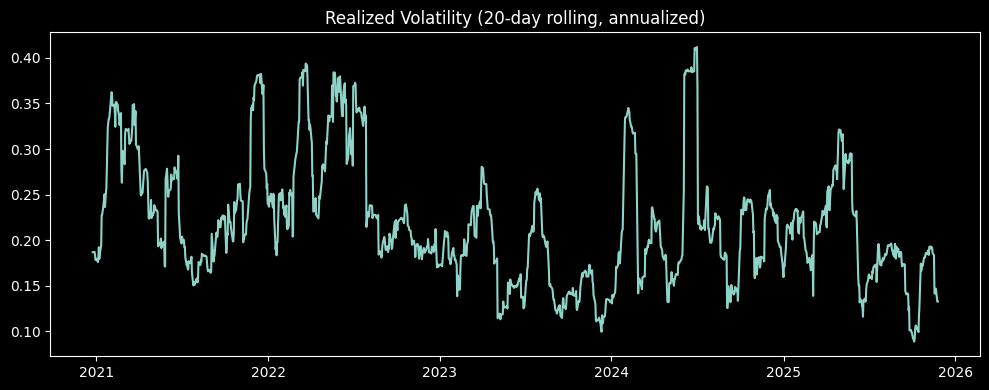

In [185]:
# plot rolling 20-day volatility
plt.style.use("dark_background")
plt.figure(figsize=(10,4))
plt.plot(logret.rolling(20).std()*np.sqrt(252))
plt.title("Realized Volatility (20-day rolling, annualized)")
plt.tight_layout()
plt.show()

In [186]:
#  Fit GARCH(1,1) 
am = arch_model(logret*100, vol="Garch", p=1, q=1)
res = am.fit(disp="off")


In [187]:
f = res.forecast(horizon=1)
var1_pct2 = f.variance.values[-1,0]
sigma1_daily = np.sqrt(var1_pct2)/100     # convert percent -> decimal
sigma1_annual = sigma1_daily * np.sqrt(252)

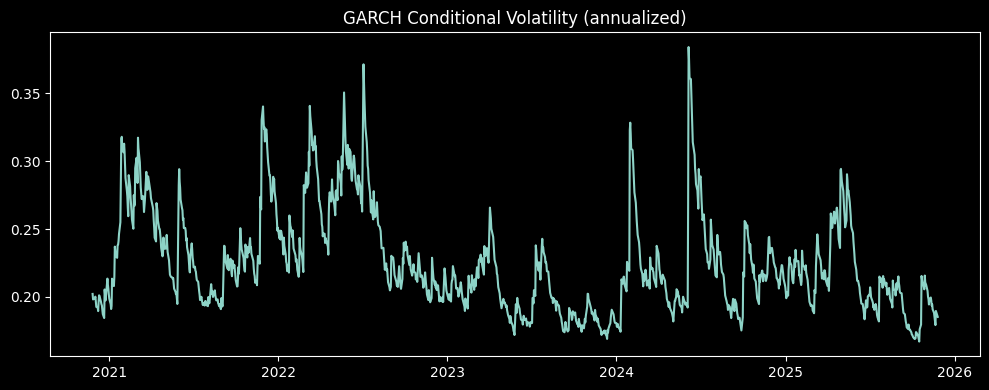

In [188]:
 #plot GARCH conditional volatility
plt.figure(figsize=(10,4))
plt.plot((res.conditional_volatility/100)*np.sqrt(252))
plt.title("GARCH Conditional Volatility (annualized)")
plt.tight_layout()
plt.show()

In [189]:
#  Monte Carlo Pricer using sample σ and GARCH σ 
def mc_price(S0, K, r, sigma, T, N):
    z = rng.standard_normal(N//2)
    z = np.concatenate([z, -z])
    ST = S0*np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*z)
    payoff = np.maximum(ST-K, 0)
    disc = np.exp(-r*T)*payoff
    return disc.mean(), disc.std(ddof=1)/np.sqrt(len(disc))

In [190]:
mc_sample, se_sample = mc_price(S0, S0, r, sigma_sample, T, N)
mc_garch, se_garch   = mc_price(S0, S0, r, sigma1_annual, T, N)


In [191]:
# ====  Black-Scholes for comparison ====
def bs_call(S0, K, r, sigma, T):
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [192]:
bs_sample = bs_call(S0, S0, r, sigma_sample, T)
bs_garch  = bs_call(S0, S0, r, sigma1_annual, T)


In [193]:
# ====  Print summary ====
print("\n===== REAL DATA + GARCH SUMMARY =====")
print("Symbol:", symbol)
print("S0 =", S0)
print("Sample volatility (annual) =", sigma_sample)
print("GARCH 1-day sigma (daily) =", sigma1_daily)
print("GARCH sigma annualized =", sigma1_annual)
print("\nUsing sample sigma:")
print(" MC =", mc_sample, "SE =", se_sample, " BS =", bs_sample)
print("\nUsing GARCH sigma:")
print(" MC =", mc_garch, "SE =", se_garch, " BS =", bs_garch)


===== REAL DATA + GARCH SUMMARY =====
Symbol: RELIANCE.NS
S0 = 1539.699951171875
Sample volatility (annual) = 0.2274687083984065
GARCH 1-day sigma (daily) = 0.01148673055558407
GARCH sigma annualized = 0.1823461945636935

Using sample sigma:
 MC = 176.39949362295278 SE = 0.8142456356902973  BS = 176.82647085513304

Using GARCH sigma:
 MC = 151.32160408820906 SE = 0.6579799748331361  BS = 150.7344531803186
